## Import Required Libraries

In [1]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
from scipy.stats import t
from statsmodels.distributions.empirical_distribution import ECDF
import diptest
import sklearn
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.cluster import normalized_mutual_info_score as NMI
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score

## DTAUC functions

In [2]:
def separation(X, point, hw): 
    """
    Compute the separation measure between the left and right neighborhoods of a given point in X.

    Parameters:
    X (list or np.array): Input 1D array.
    point (int): Index of the point to evaluate.
    hw (int): Half-window size.

    Returns:
    float: Normalized Euclidean distance between left and right neighborhoods.
    """
    n = len(X)

    # Ensure the point has enough neighbors on both sides
    if point < hw:
        return 0 # Not enough data to compute separation

    # Extract left and right neighborhoods
    if point > n-hw-1:
        return 0 
    Z1 = X[point-hw : point]
    Z2 = X[point+1 : point+hw+1]   

    # Compute Euclidean distance between the two neighborhoods
    separation = sklearn.metrics.pairwise.euclidean_distances(np.array([Z1]),np.array([Z2]))
    return separation[0][0] / (hw*hw) # Normalize by (hw * hw)


In [3]:
def best_split(X, hw = 10):
    """
    Find the best threshold for splitting the data based on properties of unimodality and separation.

    Parameters:
    X (list or np.array): Input 1D data array.
    hw (int): Half-window size for separation computation.

    Returns:
    tuple: (Best threshold value, corresponding maximum score)
    """
    
    X.sort()
    n = len(X)
    
    thvector = []  # Stores threshold values (midpoints of adjacent values)
    pvector = []   # Stores p-values
    sepvector = []  # Stores separation scores
    
    for i in range(n-1):
        th = np.mean([X[i],X[i+1]]) # Compute midpoint between adjacent values
        thvector.append(th) 

        # Compute separation for this split point
        sepvector.append(separation(X, i, hw))

        # Split data based on threshold
        Xplus = X[X>=th]
        Xminus = X[X<th]

        # Perform diptest for each partition
        _, pplus = diptest.diptest(Xplus)
        _, pminus = diptest.diptest(Xminus)

        # Compute weighted p-value
        alpha = len(Xminus) / n
        pp = alpha * pminus + (1-alpha) * pplus      
        pvector.append(pp)
        
    # Multiply p-value and separation scores element-wise
    pvector = [x*y for x,y in zip(pvector,sepvector)]  

    # Find maximum value and its corresponding index
    maxval, maxind = max([(val,ind) for ind, val in enumerate(pvector)])    
    
    # Retrieve the corresponding threshold
    threshold = thvector[maxind]
    
    return threshold, maxval

In [4]:
def multidim_split(X, alpha=0.01):   
    """
    Recursively splits a multidimensional dataset based on dip-test of unimodality.
    
    Parameters:
    X (np.array): 2D array where each row is a sample and each column is a feature.
    alpha (float): Significance level for dip-test (threshold for unimodality detection).

    Returns:
    list: A list of subsets after splitting, where each of them is axis unimodal (i.e., the feature of each subset is unimodal)
    """
    
    n, d = X.shape
    Sets = [X] # Initialize with the whole dataset
    C = [] # List to store axis unimodal sets
  
    for S in Sets: # Process each set iteratively
        
        thlist = [] # Stores best split threshold per feature
        pwlist = [] # Stores the p-value corresponding to the best split feature 
        
        for i in range(d):
            _, pval = diptest.diptest(S[:,i].copy()) # dip-test of unimodality for feature i
            
            if pval <= alpha: # if multimodal
                th, pw = best_split(S[:,i].copy())
                
            else:
                th = [] # No valid threshold
                pw = -1 # Negative power to indicate no split
                
            thlist.append(th)
            pwlist.append(pw)

        # Find the best feature to split on
        maxval, maxind = max([(val,ind) for ind, val in enumerate(pwlist)]) 
        
        if maxval > 0:  # If a valid split is found           
            split_p = thlist[maxind]
            print(f"Feature: {maxind}  |  Split_point: {split_p:.4f}")

            # Perform the split
            Ip = S[:,maxind]>=split_p
            Sp = S[Ip==True, :] # Subset where feature >= threshold
            Im = S[:,maxind]<split_p
            Sm = S[Im==True, :] # Subset where feature < threshold
            
            Sets.append(Sp)
            Sets.append(Sm)
        else:
            C.append(S) # Store unimodal subset
            
    return C

In [5]:
def compute_labels(X, alpha = 0.01):
    """
    Assigns labels to data points based on the clustering from multidim_split.
    
    Parameters:
    X (np.array): 2D dataset where each row is a sample.
    alpha (float): Significance level for dip-test in multimodality detection.

    Returns:
    tuple: (List of clusters, NumPy array of labels)
    """
    
    C = multidim_split(X, alpha) # Perform recursive splitting
    labels = np.zeros((len(X))) # Initialize label array
    
    for i in range(len(C)):
        for c in C[i]:
            labels[np.where(np.all(X == c,axis=1))] = i # Assign the corresponding label
            
    return C, labels

In [6]:
def run_DTAUC(X, alphas = [0.01, 0.05, 0.1]):
    """
    Runs the clustering method for different significance levels and evaluates the results.
    
    Parameters:
    X (np.array): Feature matrix (samples × features).
    y (np.array, optional): Ground truth labels for NMI computation. Defaults to None.
    alphas (list): List of significance levels to test.

    Returns:
    np.array: Cluster labels for the last tested alpha.
    """
    
    for sign_level in alphas:
        C, labels = compute_labels(X.copy(), alpha=sign_level) # Compute clusters and labels
        if len(set(labels)) > 1:
            print(f"*** alpha={sign_level}  |  X shape: {X.shape}  |  NMI: {NMI(y, labels):.2f}  |  Silh: {silhouette_score(X, labels):.2f}  |  Num of clusters: {len(set(labels))}\n")

    return labels

## Demo - Examples 

### Example 1 - Synthetic dataset

((750, 3), 4)

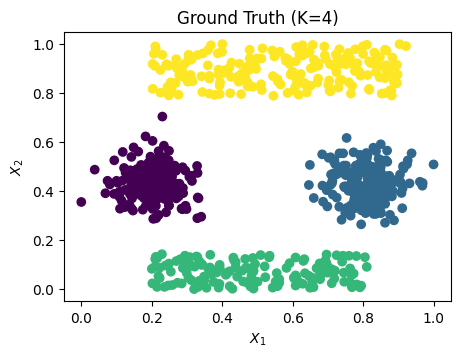

In [7]:
# Read the saved dataset
name = '2gaus_2rect_3dims.csv'
df = pd.read_csv(name)

# Extract features and labels
y = np.array(df.iloc[:,-1])
X = np.array(df.iloc[:,:-1])

# Normalize features to [0,1] range
scaler = MinMaxScaler(feature_range = (0, 1)) 
X = scaler.fit_transform(X)

# Plot ground truth
plt.figure(figsize=(5,3.5))
plt.title(f"Ground Truth (K={len(set(y))})")
plt.xlabel(r"$\mathit{" + "X_1" + "}$")
plt.ylabel(r"$\mathit{" + "X_2" + "}$")
plt.scatter(X[:,0], X[:,1], c=y)

# Display dataset shape and number of unique labels
X.shape, len(set(y))

In [8]:
# Run the method for alpha = 0.01, 0.05, 0.1
labels1 = run_DTAUC(X, alphas = [0.01])
labels2 = run_DTAUC(X, alphas = [0.05])
labels3 = run_DTAUC(X, alphas = [0.1])

Feature: 1  |  Split_point: 0.7465
Feature: 1  |  Split_point: 0.2674
Feature: 0  |  Split_point: 0.6475
*** alpha=0.01  |  X shape: (750, 3)  |  NMI: 0.99  |  Silh: 0.32  |  Num of clusters: 4

Feature: 1  |  Split_point: 0.7465
Feature: 1  |  Split_point: 0.2674
Feature: 0  |  Split_point: 0.6475
*** alpha=0.05  |  X shape: (750, 3)  |  NMI: 0.99  |  Silh: 0.32  |  Num of clusters: 4

Feature: 1  |  Split_point: 0.7465
Feature: 2  |  Split_point: 0.5345
Feature: 1  |  Split_point: 0.2674
Feature: 0  |  Split_point: 0.3915
Feature: 0  |  Split_point: 0.6475
Feature: 1  |  Split_point: 0.9110
Feature: 2  |  Split_point: 0.7166
*** alpha=0.1  |  X shape: (750, 3)  |  NMI: 0.85  |  Silh: 0.29  |  Num of clusters: 8



Text(0, 0.5, '$\\mathit{X_2}$')

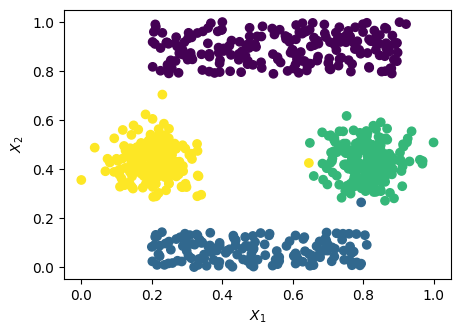

In [9]:
plt.figure(figsize=(5,3.5))
plt.scatter(X[:,0], X[:,1], c=labels1)
plt.xlabel(r"$\mathit{" + "X_1" + "}$")
plt.ylabel(r"$\mathit{" + "X_2" + "}$")

### Example 2 - Lsun dataset

((400, 2), 3)

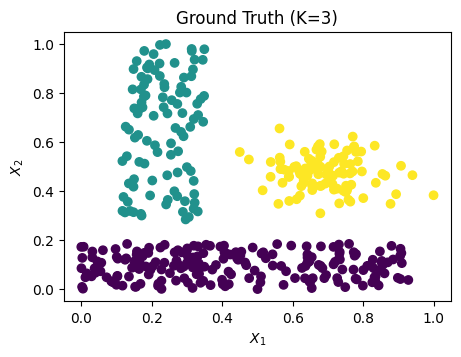

In [10]:
# Read the saved dataset
name = 'Lsun.csv'
df = pd.read_csv(name)

# Extract features and labels
y = df.iloc[:,-1]
X = np.array(df.iloc[:,:-1])

# Normalize features to [0,1] range
scaler = MinMaxScaler(feature_range = (0, 1)) 
X = scaler.fit_transform(X)

# Plot ground truth
plt.figure(figsize=(5,3.5))
plt.title(f"Ground Truth (K={len(set(y))})")
plt.xlabel(r"$\mathit{" + "X_1" + "}$")
plt.ylabel(r"$\mathit{" + "X_2" + "}$")
plt.scatter(X[:,0], X[:,1], c=y)
X.shape, len(set(y))

In [11]:
labels1 = run_DTAUC(X, alphas = [0.01])
labels2 = run_DTAUC(X, alphas = [0.05])
labels3 = run_DTAUC(X, alphas = [0.1])

Feature: 1  |  Split_point: 0.2891
Feature: 0  |  Split_point: 0.4628
*** alpha=0.01  |  X shape: (400, 2)  |  NMI: 0.97  |  Silh: 0.44  |  Num of clusters: 3

Feature: 1  |  Split_point: 0.2891
Feature: 0  |  Split_point: 0.4628
*** alpha=0.05  |  X shape: (400, 2)  |  NMI: 0.97  |  Silh: 0.44  |  Num of clusters: 3

Feature: 1  |  Split_point: 0.2891
Feature: 0  |  Split_point: 0.4628
*** alpha=0.1  |  X shape: (400, 2)  |  NMI: 0.97  |  Silh: 0.44  |  Num of clusters: 3



Text(0, 0.5, '$\\mathit{X_2}$')

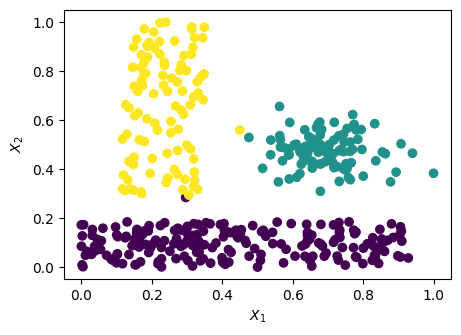

In [12]:
plt.figure(figsize=(5,3.5))
plt.scatter(X[:,0], X[:,1], c=labels1)

plt.xlabel(r"$\mathit{" + "X_1" + "}$")
plt.ylabel(r"$\mathit{" + "X_2" + "}$")